<a href="https://colab.research.google.com/github/dickyadem/classification-image-interest-with-CNN-architecture-and-Transfer-Learning-ResNet-using-Pytorch/blob/main/CNN_dan_ResNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Classification 



In [ ]:
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 217M/225M [00:10<00:00, 23.1MB/s]
100% 225M/225M [00:10<00:00, 22.8MB/s]


In [ ]:
!unzip '/content/flowers-recognition.zip' -d '/content/flowers-recognition'

Archive:  /content/flowers-recognition.zip
  inflating: /content/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: /content/flowers-recognition/flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: 

In [ ]:
data_dir ="/content/flowers-recognition/flowers"
data_dir

'/content/flowers-recognition/flowers'

In [ ]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [ ]:
database.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'rose':2 ,
                  'sunflower':3 ,
                  'tulip':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

#Val_set and train_set

In [ ]:
validation_size = 500
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[450, 50 ])
len(train_ds), len(val_ds)


(3817, 450)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

# 1. Training Image Classification 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = FlowerModel()
model

FlowerModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
 for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([ 0.0041,  0.0334,  0.0108, -0.0332,  0.0388],
       grad_fn=<SelectBackward0>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Training Model

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


In [ ]:
model = to_device(FlowerModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.16458334028720856, 'val_loss': 1.615053653717041}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
%%time
try1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2803, val_loss: 1.0639, val_acc: 0.4979
Epoch [1], train_loss: 1.0811, val_loss: 0.9805, val_acc: 0.5604
Epoch [2], train_loss: 1.0162, val_loss: 0.9736, val_acc: 0.5458
Epoch [3], train_loss: 0.9212, val_loss: 0.9013, val_acc: 0.5833
Epoch [4], train_loss: 0.8784, val_loss: 0.8820, val_acc: 0.6375
Epoch [5], train_loss: 0.8353, val_loss: 0.7854, val_acc: 0.6479
Epoch [6], train_loss: 0.7901, val_loss: 0.7987, val_acc: 0.6396
Epoch [7], train_loss: 0.7710, val_loss: 0.8018, val_acc: 0.6646
Epoch [8], train_loss: 0.7266, val_loss: 0.7004, val_acc: 0.6542
Epoch [9], train_loss: 0.7009, val_loss: 0.8406, val_acc: 0.6667
CPU times: user 7min 19s, sys: 8.05 s, total: 7min 27s
Wall time: 7min 28s


In [ ]:
def plot_accuracies(try1):
    accuracies = [x['val_acc'] for x in try1]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

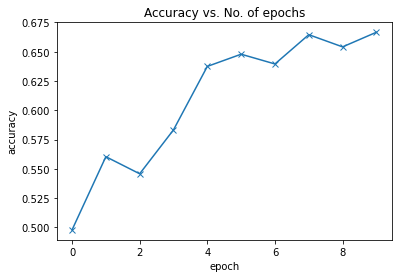

In [ ]:
plot_accuracies(try1)

In [ ]:
def plot_losses(try1):
    train_losses = [x.get('train_loss') for x in try1]
    val_losses = [x['val_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

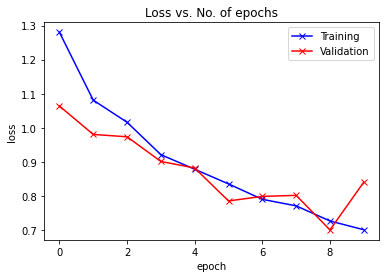

In [ ]:
plot_losses(try1)

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_acc': 0.6649305820465088, 'val_loss': 1.156876564025879}

# Predict the image 

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: dandelion , Predicted: tulip


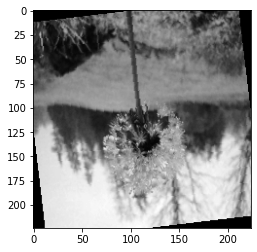

In [ ]:
img, label = test_ds[45]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: sunflower , Predicted: rose


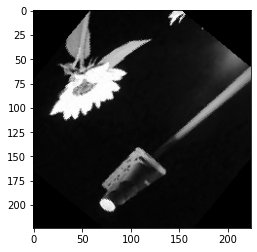

In [ ]:
img, label = test_ds[46]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: dandelion , Predicted: tulip


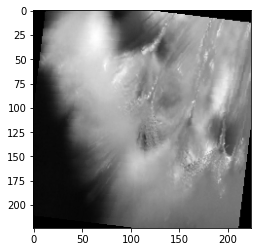

In [ ]:
img, label = test_ds[47]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: dandelion , Predicted: tulip


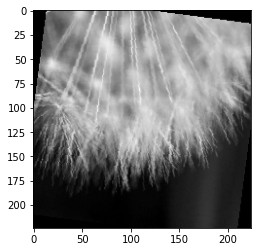

In [ ]:
img, label = test_ds[48]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# 1. Transfer Learning using Restnet18 (Pre-trained) 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'val_acc': 0.17083333432674408, 'val_loss': 1.622490406036377}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1855, val_loss: 1.4355, val_acc: 0.4521
Epoch [1], train_loss: 1.1405, val_loss: 1.1193, val_acc: 0.7292
Epoch [2], train_loss: 1.1070, val_loss: 1.2187, val_acc: 0.6125
Epoch [3], train_loss: 1.1146, val_loss: 1.1097, val_acc: 0.7396
Epoch [4], train_loss: 1.0898, val_loss: 1.0764, val_acc: 0.7937
Epoch [5], train_loss: 1.0764, val_loss: 1.1500, val_acc: 0.7312
Epoch [6], train_loss: 1.0715, val_loss: 1.0532, val_acc: 0.8271
Epoch [7], train_loss: 1.0697, val_loss: 1.0814, val_acc: 0.8062
Epoch [8], train_loss: 1.0692, val_loss: 1.1031, val_acc: 0.7583
Epoch [9], train_loss: 1.0579, val_loss: 1.1621, val_acc: 0.7063
CPU times: user 3min 30s, sys: 10.2 s, total: 3min 40s
Wall time: 3min 41s


In [ ]:
evaluate(model, test_dl)


{'val_acc': 0.7118055820465088, 'val_loss': 1.1035563945770264}

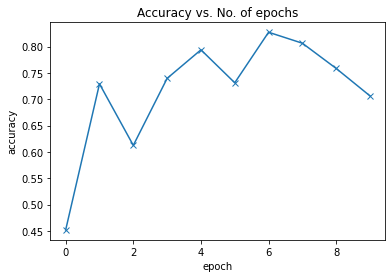

In [ ]:
def plot_accuracies(try3):
    accuracies = [x['val_acc'] for x in try3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try3)

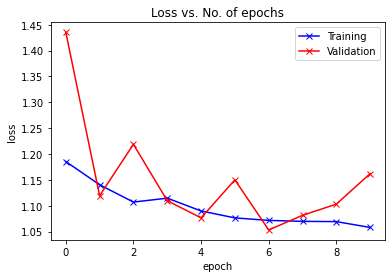

In [ ]:
def plot_losses(try3):
    train_losses = [x.get('train_loss') for x in try3]
    val_losses = [x['val_loss'] for x in try3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try3)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: sunflower , Predicted: sunflower


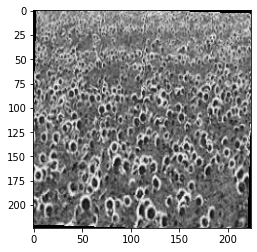

In [ ]:
img, label = test_ds[17]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))


Label: dandelion , Predicted: dandelion


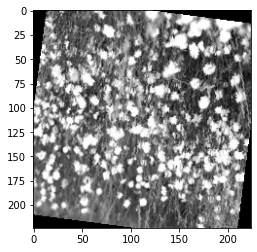

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))



In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

# 2. Resnet 34

In [ ]:
class FlowerModelResnet34(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model = to_device(FlowerModelResnet34(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

{'val_acc': 0.18125000596046448, 'val_loss': 1.6337617635726929}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.2310, val_loss: 1.2214, val_acc: 0.6021
Epoch [1], train_loss: 1.1849, val_loss: 1.1508, val_acc: 0.6750
Epoch [2], train_loss: 1.1664, val_loss: 1.2351, val_acc: 0.6542
Epoch [3], train_loss: 1.1382, val_loss: 1.1461, val_acc: 0.7021
Epoch [4], train_loss: 1.1253, val_loss: 1.1892, val_acc: 0.6875
Epoch [5], train_loss: 1.1167, val_loss: 1.1132, val_acc: 0.7563
Epoch [6], train_loss: 1.1184, val_loss: 1.1137, val_acc: 0.7000
Epoch [7], train_loss: 1.1167, val_loss: 1.1324, val_acc: 0.7479
Epoch [8], train_loss: 1.0947, val_loss: 1.1435, val_acc: 0.7292
Epoch [9], train_loss: 1.0961, val_loss: 1.0837, val_acc: 0.7688
CPU times: user 4min 59s, sys: 1min 31s, total: 6min 31s
Wall time: 6min 31s


In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.6649305820465088, 'val_loss': 1.154125690460205}

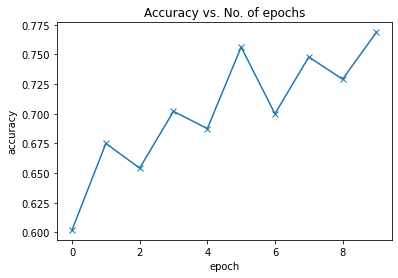

In [ ]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

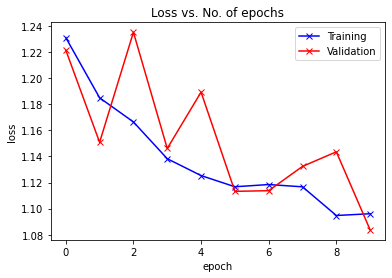

In [ ]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: dandelion , Predicted: dandelion


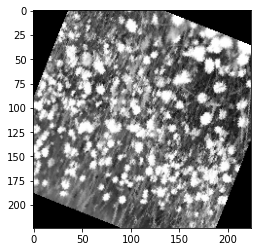

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet34()))

Label: daisy , Predicted: tulip


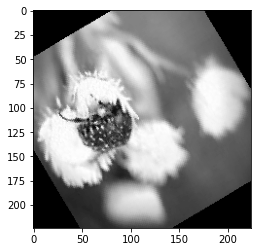

In [ ]:
img, label = test_ds[9]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet34()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

# 3. Transfer Learning method using Restnet50 (Pre-trained) 

In [ ]:
class FlowerModelResnet50(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(FlowerModelResnet50(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

{'val_acc': 0.17499999701976776, 'val_loss': 1.622903823852539}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try5 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.2504, val_loss: 1.2710, val_acc: 0.5771
Epoch [1], train_loss: 1.2465, val_loss: 1.2683, val_acc: 0.5688
Epoch [2], train_loss: 1.2099, val_loss: 1.2117, val_acc: 0.6292
Epoch [3], train_loss: 1.1960, val_loss: 1.1621, val_acc: 0.7083
Epoch [4], train_loss: 1.1870, val_loss: 1.1880, val_acc: 0.6417
Epoch [5], train_loss: 1.1986, val_loss: 1.2173, val_acc: 0.6104
Epoch [6], train_loss: 1.1903, val_loss: 1.1895, val_acc: 0.6292
Epoch [7], train_loss: 1.1778, val_loss: 1.1651, val_acc: 0.6750
Epoch [8], train_loss: 1.1657, val_loss: 1.1668, val_acc: 0.6250
Epoch [9], train_loss: 1.1549, val_loss: 1.1250, val_acc: 0.6750
CPU times: user 7min 1s, sys: 3min 34s, total: 10min 35s
Wall time: 10min 36s


In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.6770833730697632, 'val_loss': 1.1443119049072266}

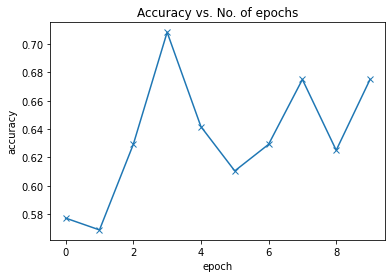

In [ ]:
def plot_accuracies(try5):
    accuracies = [x['val_acc'] for x in try5]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try5)

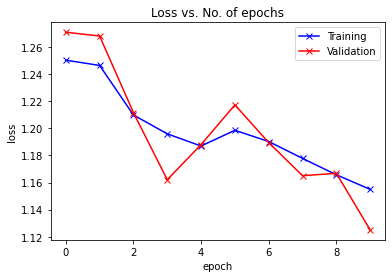

In [ ]:
def plot_losses(try5):
    train_losses = [x.get('train_loss') for x in try5]
    val_losses = [x['val_loss'] for x in try5]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try5)

Predict image

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: daisy , Predicted: rose


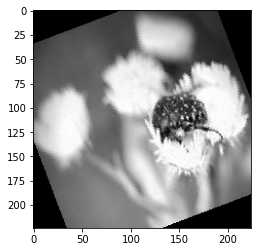

In [ ]:
img, label = test_ds[9]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

Label: dandelion , Predicted: rose


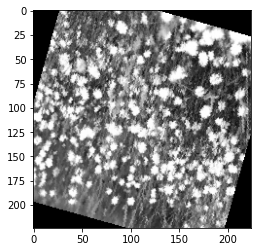

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet50()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')

# Transfer Learning method using Restnet101 (Pre-trained) 

In [ ]:
class FlowerModelResnet101(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model = to_device(FlowerModelResnet101(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

{'val_acc': 0.19166666269302368, 'val_loss': 1.6200412511825562}

In [ ]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [ ]:
%%time
try4 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.2025, val_loss: 1.2685, val_acc: 0.5292
Epoch [1], train_loss: 1.1933, val_loss: 1.1664, val_acc: 0.6187
Epoch [2], train_loss: 1.1815, val_loss: 1.1624, val_acc: 0.5896
Epoch [3], train_loss: 1.1671, val_loss: 1.1997, val_acc: 0.5833
Epoch [4], train_loss: 1.1746, val_loss: 1.1555, val_acc: 0.6083
Epoch [5], train_loss: 1.1586, val_loss: 1.1571, val_acc: 0.5958
Epoch [6], train_loss: 1.1733, val_loss: 1.3177, val_acc: 0.4708
Epoch [7], train_loss: 1.1973, val_loss: 1.1892, val_acc: 0.5708
Epoch [8], train_loss: 1.1681, val_loss: 1.1609, val_acc: 0.6187
Epoch [9], train_loss: 1.1638, val_loss: 1.1524, val_acc: 0.6167
CPU times: user 9min 48s, sys: 5min 54s, total: 15min 43s
Wall time: 15min 44s


In [ ]:
evaluate(model, test_dl)

{'val_acc': 0.6805555820465088, 'val_loss': 1.1269207000732422}

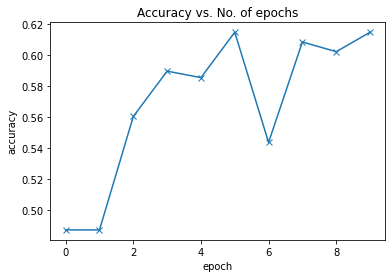

In [ ]:
def plot_accuracies(try4):
    accuracies = [x['val_acc'] for x in try4]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try4)

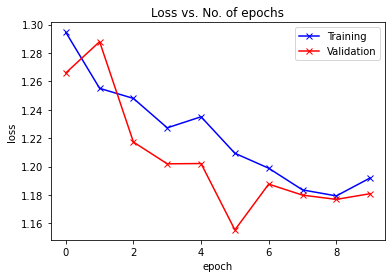

In [ ]:
def plot_losses(try4):
    train_losses = [x.get('train_loss') for x in try4]
    val_losses = [x['val_loss'] for x in try4]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try4)

Predict

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Label: daisy , Predicted: tulip


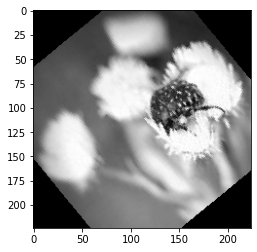

In [ ]:
img, label = test_ds[9]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet101()))

Label: dandelion , Predicted: sunflower


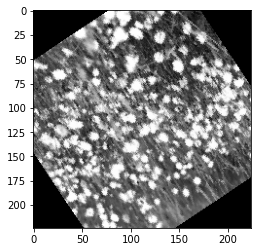

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModelResnet101()))

In [ ]:
torch.save(model.state_dict(), 'Flower-classification.pth')